# Local-Global-Trend(LGT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - June 2018. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [2]:
DATA_FILE = "./data/iclaims_example.csv"
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

We preprocess the data by log transformation to turn model from `additive` to `multiplicative`.

In [3]:
df=raw_df.copy()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [5]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


## MAP Fit and Predict

In [7]:
lgt_map=LGTMAP(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
)

In [8]:
%%time
lgt_map.fit(df=train_df)

CPU times: user 211 ms, sys: 10.5 ms, total: 221 ms
Wall time: 545 ms


In [11]:
predicted_df = lgt_map.predict(df=test_df)

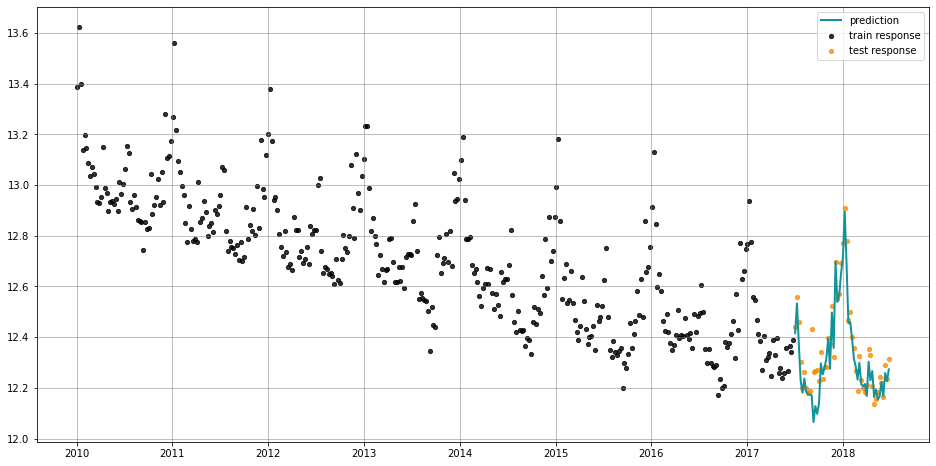

In [12]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, 
                    pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [13]:
lgt = LGTFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    num_warmup=4000, 
    num_sample=500,
    n_bootstrap_draws=-1,
    prediction_percentiles=[5, 95],
)

In [14]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 129 ms, sys: 145 ms, total: 273 ms
Wall time: 22.1 s


In [18]:
predicted_df = lgt.predict(df=test_df)

In [19]:
predicted_df.tail(3)

,week,5,prediction,95
49,2018-06-10,12.139822,12.268596,12.383695
50,2018-06-17,12.114117,12.232192,12.346645
51,2018-06-24,12.148947,12.281144,12.387796


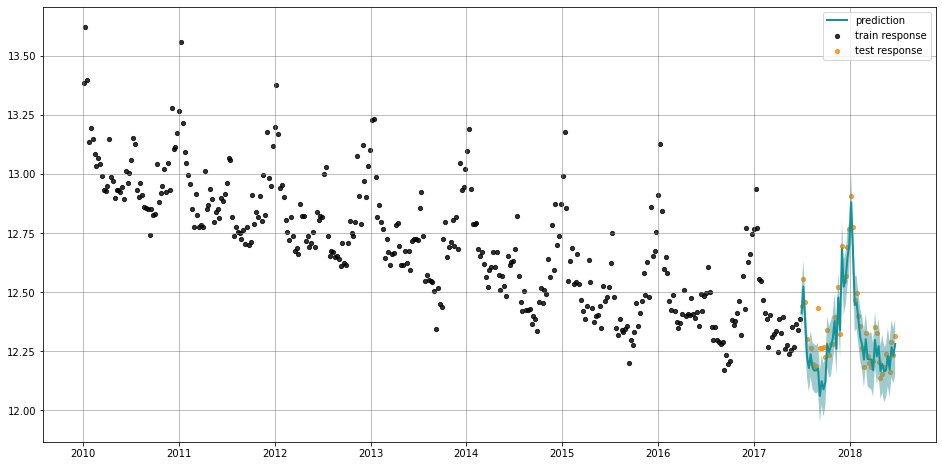

In [20]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, pred_col='prediction', 
                    pred_percentiles_col=[5, 95],
                    test_actual_df=test_df)

## Mean Fit

In [21]:
lgt_agg=LGTAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    num_warmup=4000, 
    num_sample=500,
)

In [22]:
%%time
lgt_agg.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 148 ms, sys: 165 ms, total: 314 ms
Wall time: 22.2 s


In [23]:
predicted_df = lgt_agg.predict(df=test_df)

In [24]:
predicted_df.tail(3)

,week,prediction
49,2018-06-10,12.228364
50,2018-06-17,12.195717
51,2018-06-24,12.241649


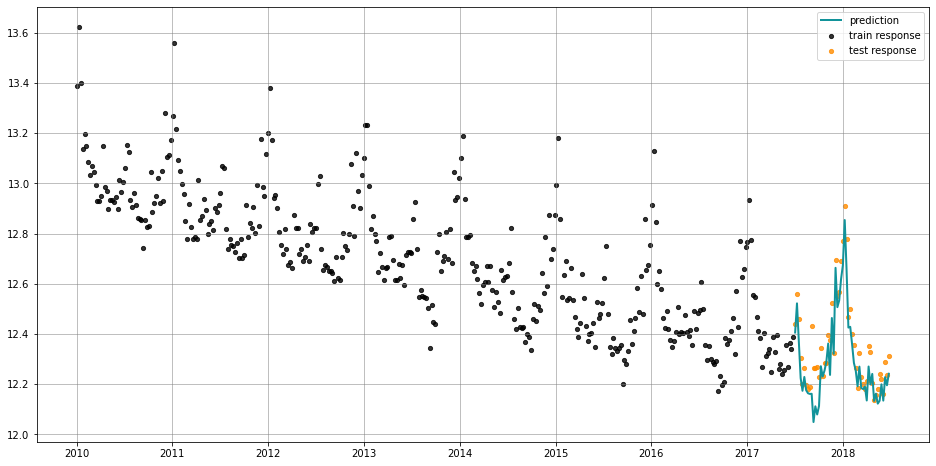

In [25]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_agg.date_col, actual_col=lgt_agg.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors & Predict with Decomp

### Fit with Regressors

In [26]:
lgt_reg=LGTMAP(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
)

In [27]:
%%time
lgt_reg.fit(df=train_df)

CPU times: user 245 ms, sys: 9.43 ms, total: 255 ms
Wall time: 262 ms


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [28]:
# make prediction of past and future
predicted_df = lgt_reg.predict(df=df, decompose=True)
predicted_df.head(3)

,week,prediction,trend,seasonality,regression
0,2010-01-03,13.386595,13.112540,0.291839,-0.017784
1,2010-01-10,13.624713,13.089083,0.543926,-0.008296
2,2010-01-17,13.386052,13.085637,0.315491,-0.015076


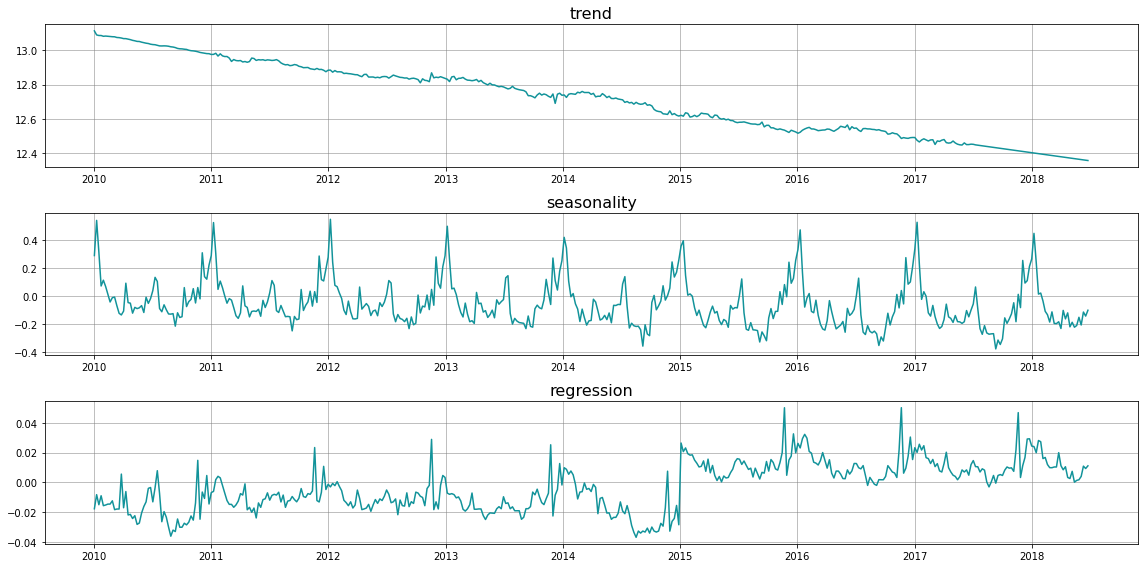

In [29]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')